In [1]:
import pennylane as qml
import numpy as np
import tensorflow as tf
import keras.models
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LeakyReLU 
import os
import time
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Networks

## Discriminator

In [2]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(1,)))
    
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation=tf.nn.sigmoid))

    return model

## Generator 

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(1,)))
    
    model.add(Dense(16))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(1))

    return model

In [4]:
generator = make_generator_model()

noise = tf.random.normal([100, 1])
generated_data = generator(noise, training=False)
#generated_data

In [5]:
discriminator = make_discriminator_model()

In [6]:
decision = discriminator(generated_data)
#decision

# Loss functions

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [8]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [9]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers 

In [10]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training

In [12]:
EPOCHS = 200
noise_dim = 1
num_examples_to_generate = 100
#BUFFER_SIZE = 60000
BATCH_SIZE = 100

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [13]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(data):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)

        real_output = discriminator(data, training=True)
        fake_output = discriminator(generated_data, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [14]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for n_batch, batch in enumerate(dataset):
            X_batch = batch.reshape(100,1)
            train_step(X_batch)
        
        test_data = generator(seed, training=False).numpy()
        plt.hist(test_data , bins = 20,  range=(0, 20), alpha=0.5, weights=np.ones(len(test_data)) / len(test_data))
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.show()


    # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  # generate_and_save_images(generator,epochs, seed)

# Data

In [15]:
# Number training data samples
N = 10000

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
data = np.random.lognormal(mean=mu, sigma=sigma, size=N)

(array([9.257e+03, 5.750e+02, 9.800e+01, 4.700e+01, 1.000e+01, 9.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([6.91614994e-02, 1.14281536e+01, 2.27871456e+01, 3.41461377e+01,
        4.55051297e+01, 5.68641218e+01, 6.82231139e+01, 7.95821059e+01,
        9.09410980e+01, 1.02300090e+02, 1.13659082e+02]),
 <BarContainer object of 10 artists>)

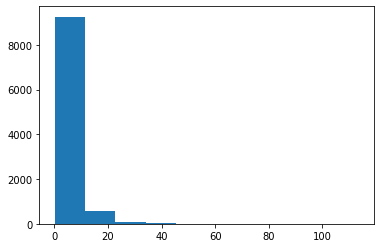

In [16]:
plt.hist(data)

In [17]:
data_loader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

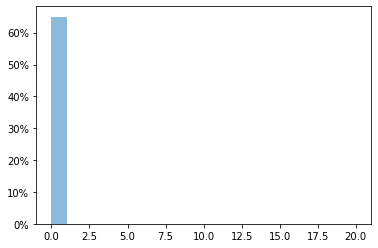

Time for epoch 1 is 0.921116828918457 sec


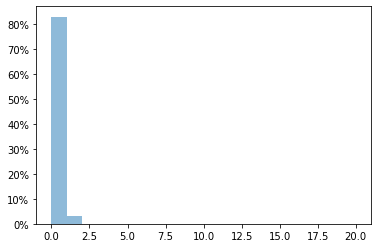

Time for epoch 2 is 0.20654654502868652 sec


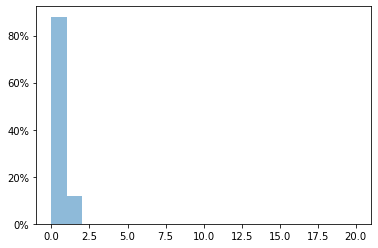

Time for epoch 3 is 0.17293286323547363 sec


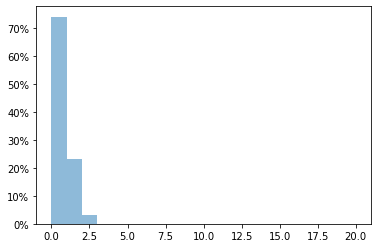

Time for epoch 4 is 0.19518041610717773 sec


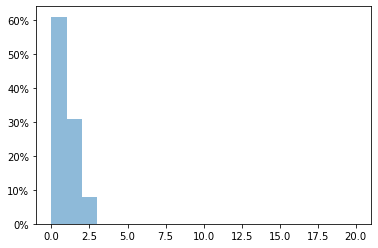

Time for epoch 5 is 0.1988506317138672 sec


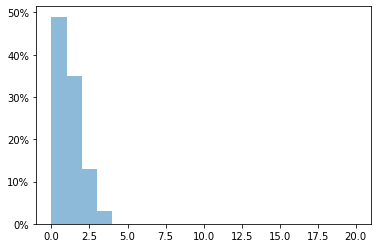

Time for epoch 6 is 0.18612980842590332 sec


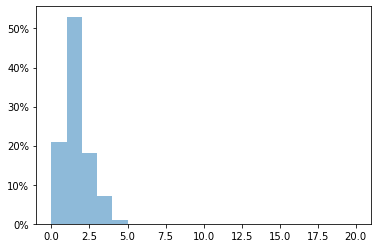

Time for epoch 7 is 0.20826983451843262 sec


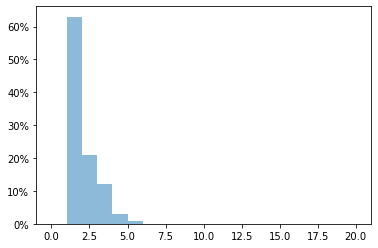

Time for epoch 8 is 0.1910707950592041 sec


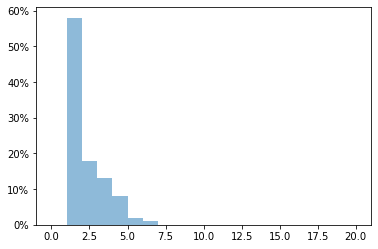

Time for epoch 9 is 0.22342348098754883 sec


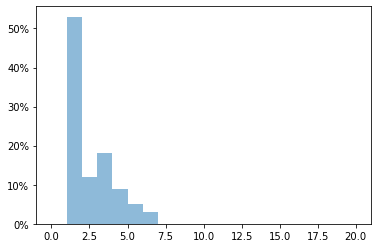

Time for epoch 10 is 0.17276883125305176 sec


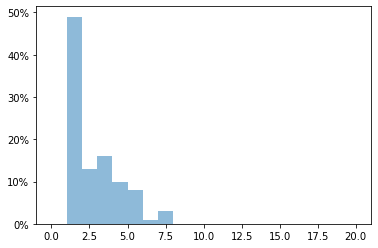

Time for epoch 11 is 0.1747443675994873 sec


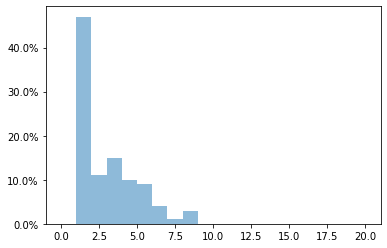

Time for epoch 12 is 0.20902752876281738 sec


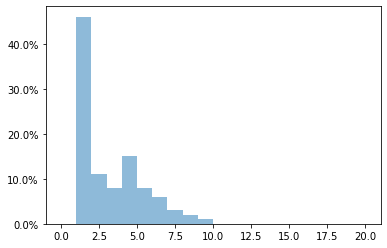

Time for epoch 13 is 0.20251822471618652 sec


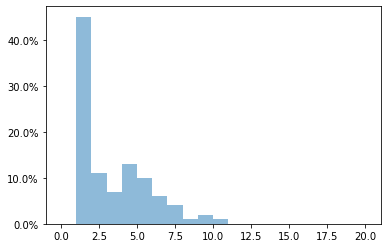

Time for epoch 14 is 0.18611860275268555 sec


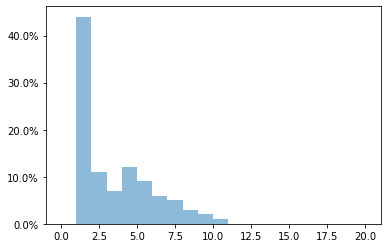

Time for epoch 15 is 0.24318265914916992 sec


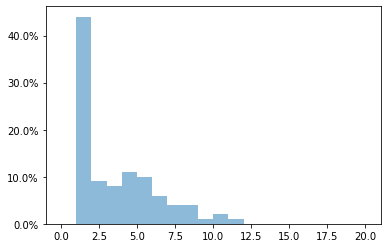

Time for epoch 16 is 0.1881568431854248 sec


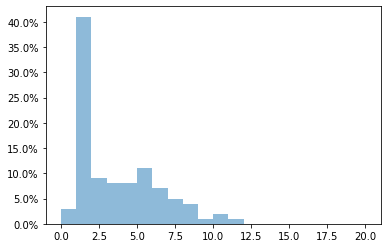

Time for epoch 17 is 0.18840408325195312 sec


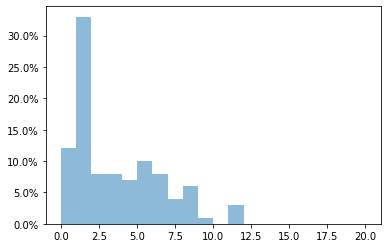

Time for epoch 18 is 0.21050572395324707 sec


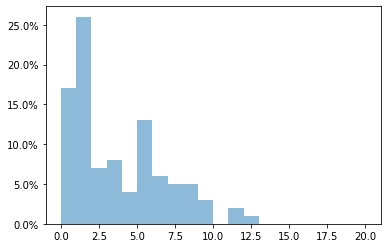

Time for epoch 19 is 0.31981444358825684 sec


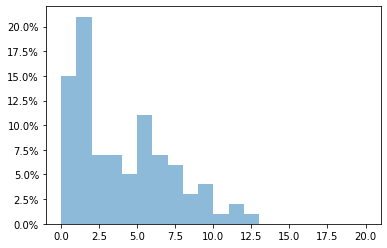

Time for epoch 20 is 0.20137262344360352 sec


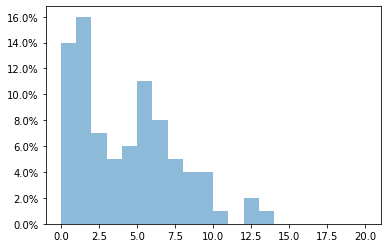

Time for epoch 21 is 0.18629741668701172 sec


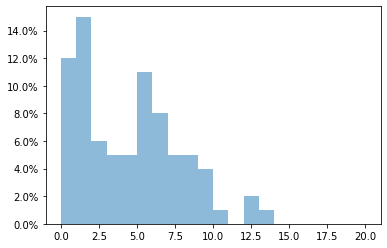

Time for epoch 22 is 0.20382094383239746 sec


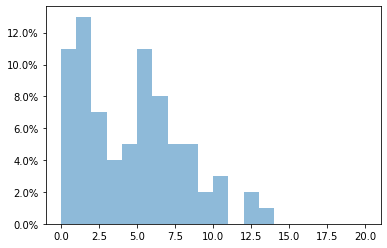

Time for epoch 23 is 0.20198583602905273 sec


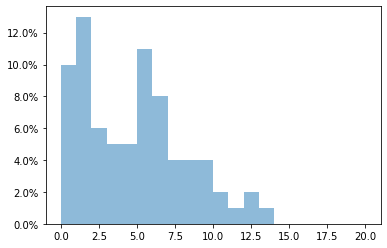

Time for epoch 24 is 0.19538259506225586 sec


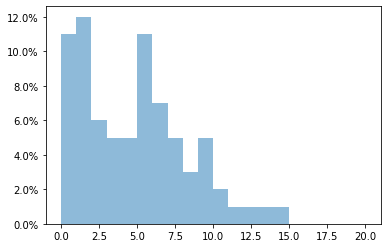

Time for epoch 25 is 0.17537236213684082 sec


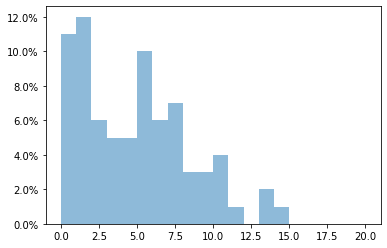

Time for epoch 26 is 0.23881053924560547 sec


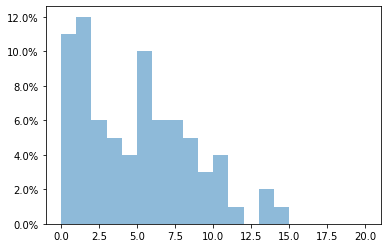

Time for epoch 27 is 0.1851029396057129 sec


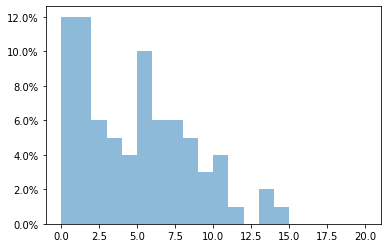

Time for epoch 28 is 0.20167088508605957 sec


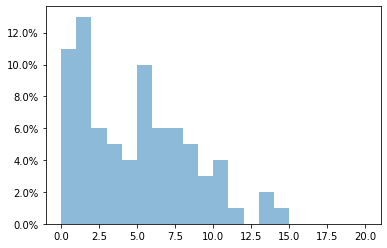

Time for epoch 29 is 0.1760091781616211 sec


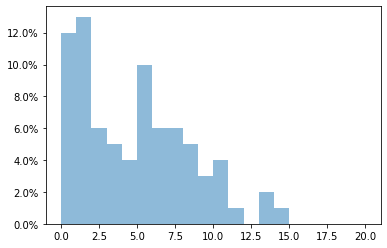

Time for epoch 30 is 0.2431795597076416 sec


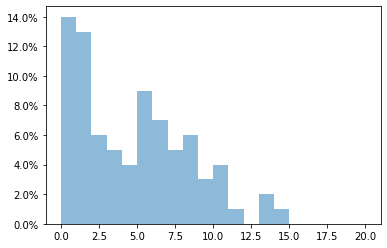

Time for epoch 31 is 0.2110428810119629 sec


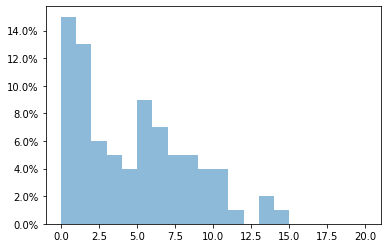

Time for epoch 32 is 0.18541741371154785 sec


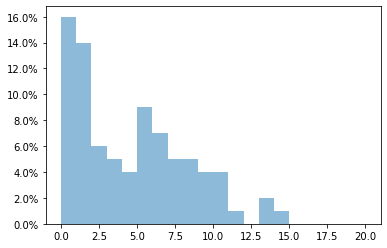

Time for epoch 33 is 0.1853482723236084 sec


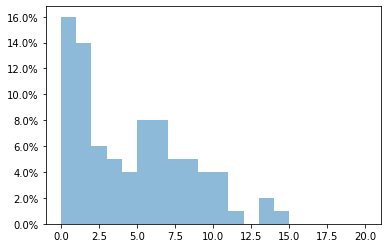

Time for epoch 34 is 0.20674610137939453 sec


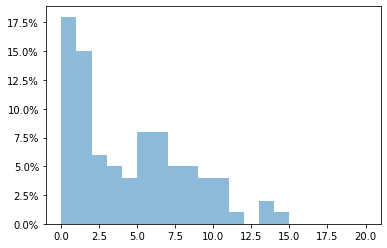

Time for epoch 35 is 0.17683863639831543 sec


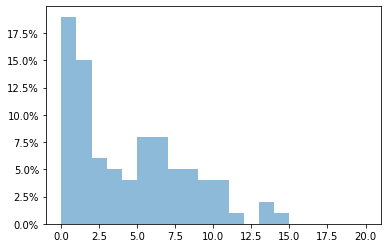

Time for epoch 36 is 0.23406505584716797 sec


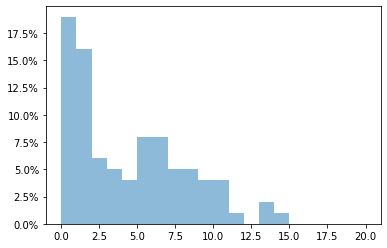

Time for epoch 37 is 0.21427631378173828 sec


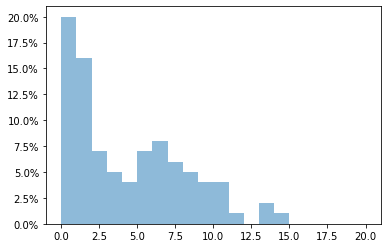

Time for epoch 38 is 0.2185966968536377 sec


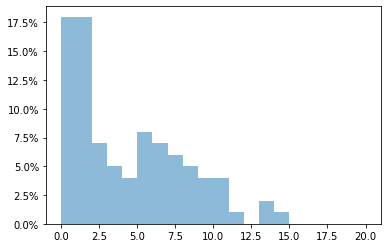

Time for epoch 39 is 0.20932912826538086 sec


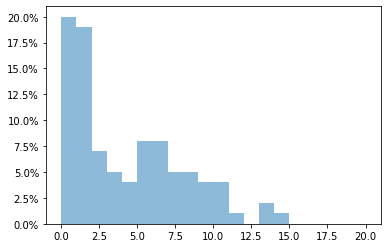

Time for epoch 40 is 0.35928773880004883 sec


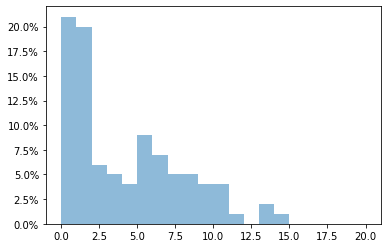

Time for epoch 41 is 0.1904008388519287 sec


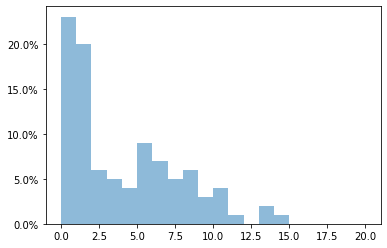

Time for epoch 42 is 0.1876230239868164 sec


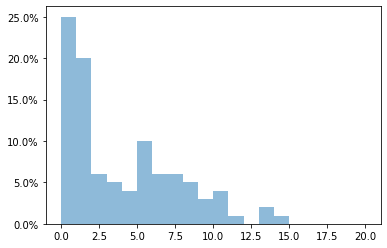

Time for epoch 43 is 0.18468809127807617 sec


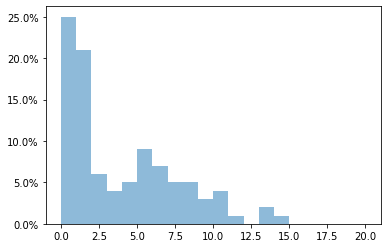

Time for epoch 44 is 0.18555545806884766 sec


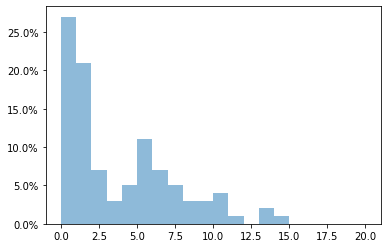

Time for epoch 45 is 0.2212679386138916 sec


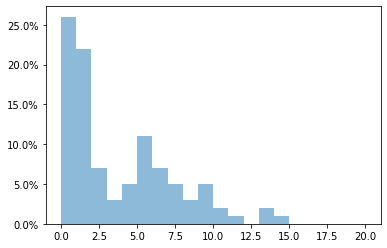

Time for epoch 46 is 0.21001243591308594 sec


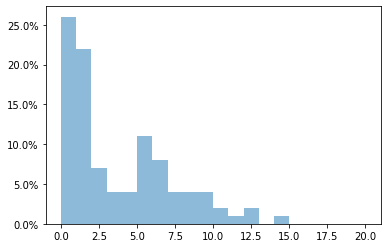

Time for epoch 47 is 0.1971888542175293 sec


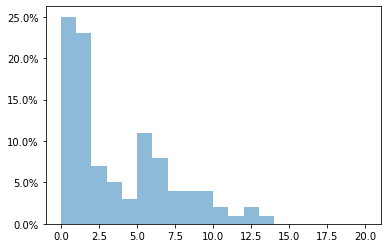

Time for epoch 48 is 0.18308782577514648 sec


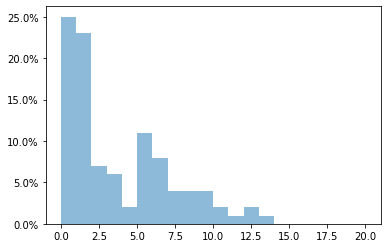

Time for epoch 49 is 0.18464922904968262 sec


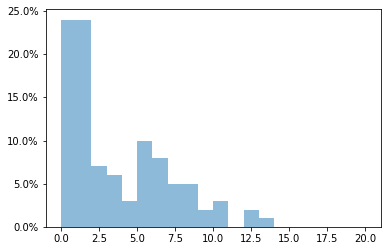

Time for epoch 50 is 0.194657564163208 sec


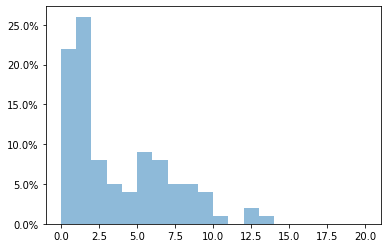

Time for epoch 51 is 0.17953085899353027 sec


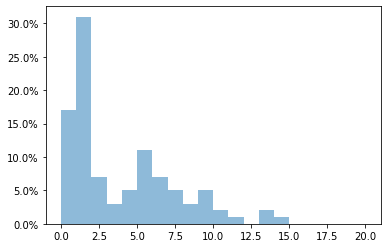

Time for epoch 52 is 0.1791543960571289 sec


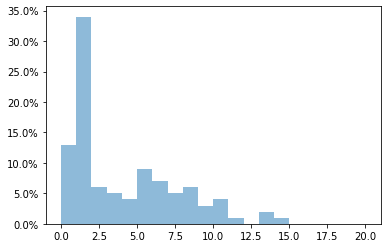

Time for epoch 53 is 0.22184228897094727 sec


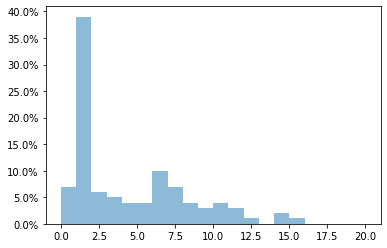

Time for epoch 54 is 0.19829297065734863 sec


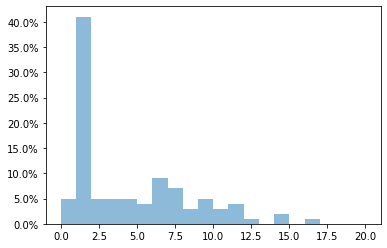

Time for epoch 55 is 0.18002867698669434 sec


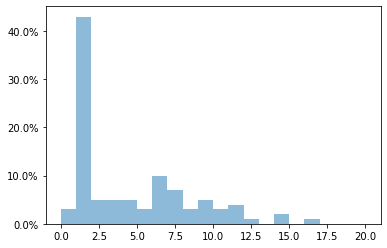

Time for epoch 56 is 0.19210553169250488 sec


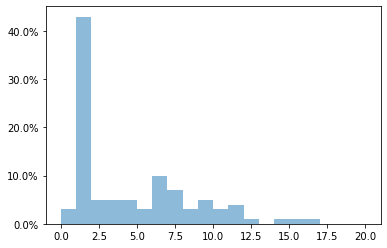

Time for epoch 57 is 0.1781601905822754 sec


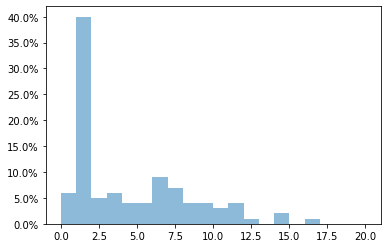

Time for epoch 58 is 0.1856403350830078 sec


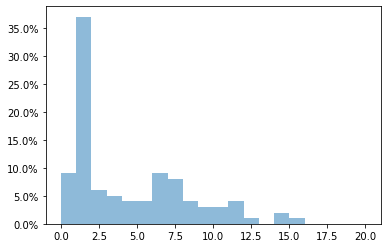

Time for epoch 59 is 0.18898797035217285 sec


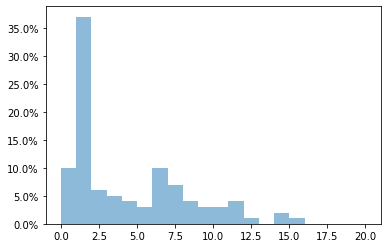

Time for epoch 60 is 0.2112898826599121 sec


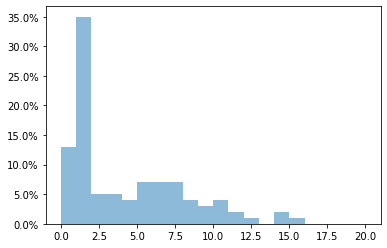

Time for epoch 61 is 0.3052177429199219 sec


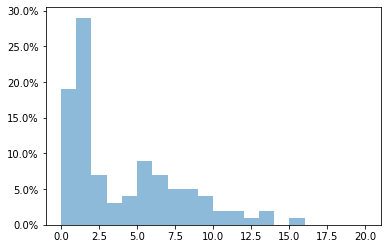

Time for epoch 62 is 0.18669390678405762 sec


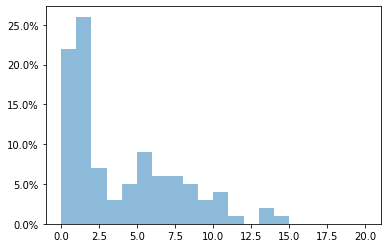

Time for epoch 63 is 0.18844270706176758 sec


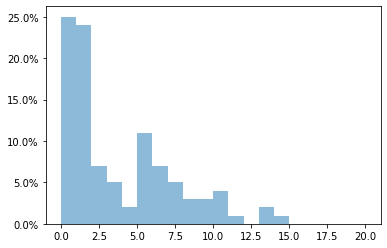

Time for epoch 64 is 0.16344285011291504 sec


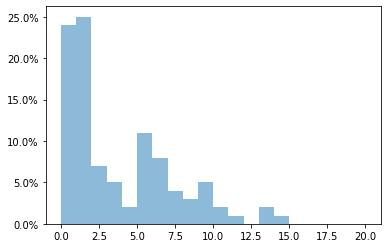

Time for epoch 65 is 0.20781302452087402 sec


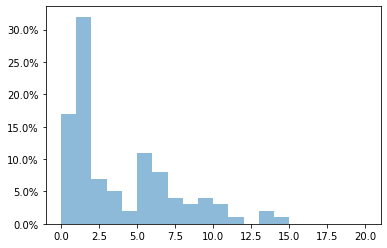

Time for epoch 66 is 0.18741154670715332 sec


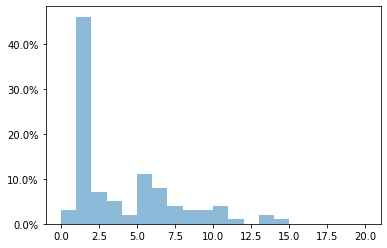

Time for epoch 67 is 0.17858147621154785 sec


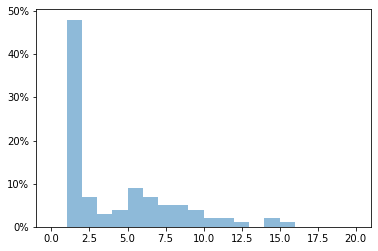

Time for epoch 68 is 0.18444561958312988 sec


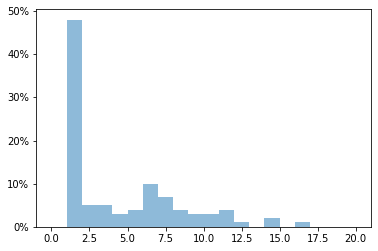

Time for epoch 69 is 0.1892101764678955 sec


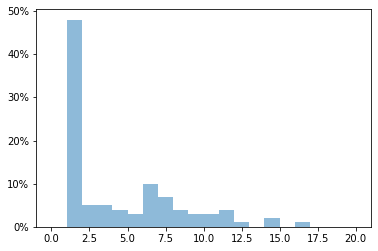

Time for epoch 70 is 0.19289278984069824 sec


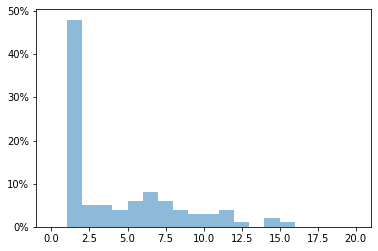

Time for epoch 71 is 0.18974947929382324 sec


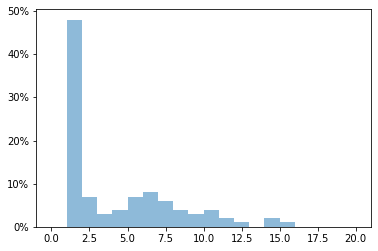

Time for epoch 72 is 0.19085979461669922 sec


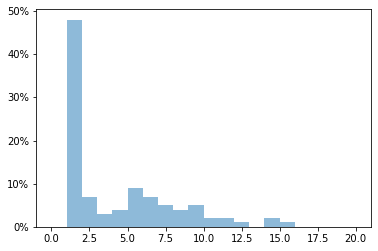

Time for epoch 73 is 0.18000555038452148 sec


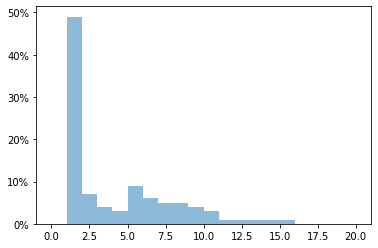

Time for epoch 74 is 0.1684257984161377 sec


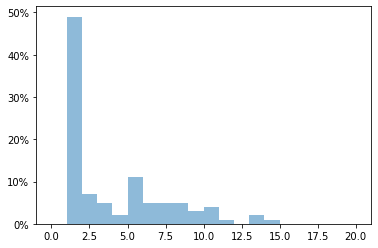

Time for epoch 75 is 0.19980287551879883 sec


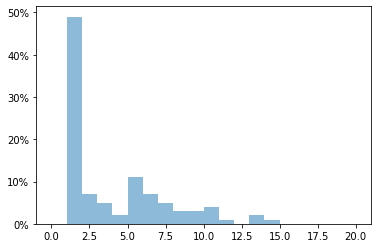

Time for epoch 76 is 0.22043657302856445 sec


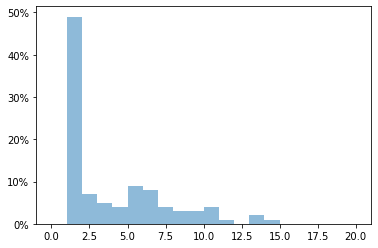

Time for epoch 77 is 0.24224138259887695 sec


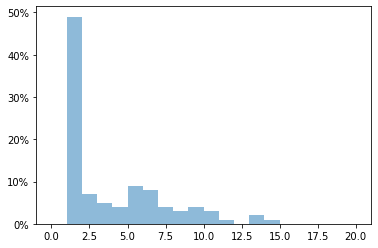

Time for epoch 78 is 0.20811843872070312 sec


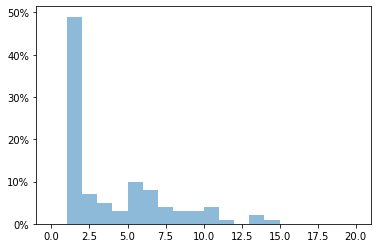

Time for epoch 79 is 0.1998586654663086 sec


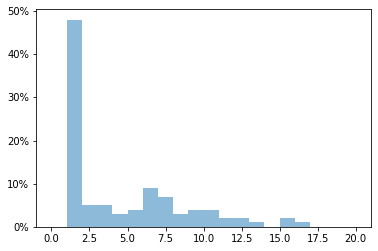

Time for epoch 80 is 0.17607927322387695 sec


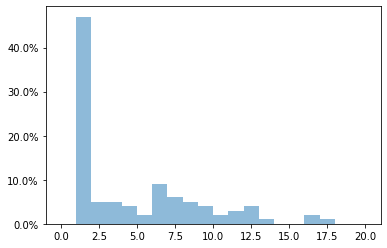

Time for epoch 81 is 0.1764228343963623 sec


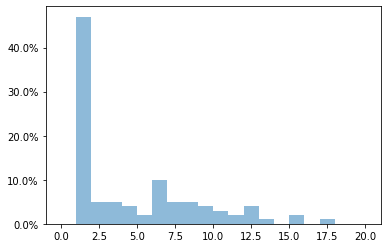

Time for epoch 82 is 0.31203770637512207 sec


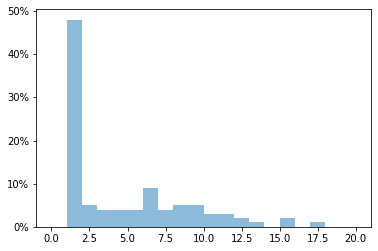

Time for epoch 83 is 0.1678931713104248 sec


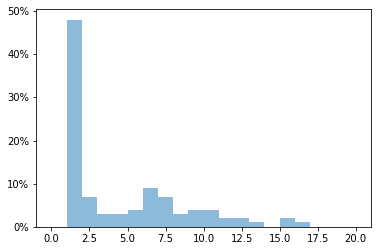

Time for epoch 84 is 0.1973247528076172 sec


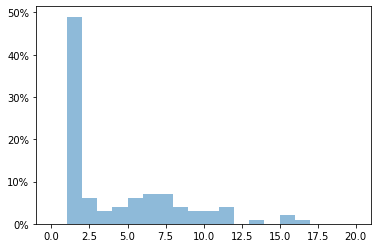

Time for epoch 85 is 0.1700742244720459 sec


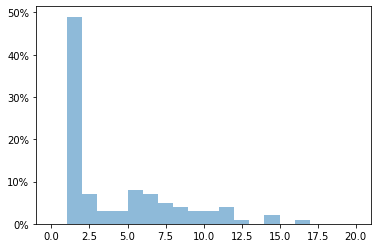

Time for epoch 86 is 0.20610880851745605 sec


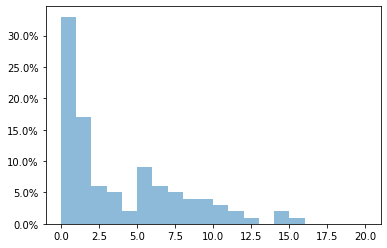

Time for epoch 87 is 0.18861865997314453 sec


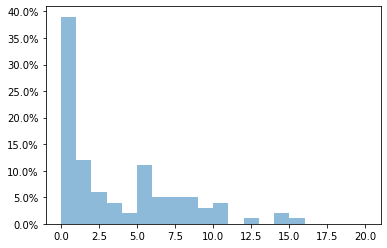

Time for epoch 88 is 0.19060325622558594 sec


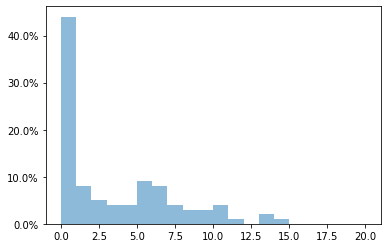

Time for epoch 89 is 0.1884012222290039 sec


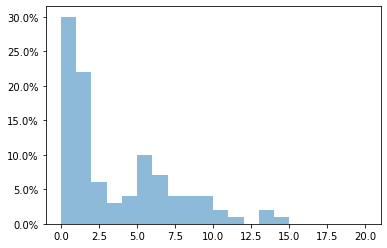

Time for epoch 90 is 0.2087702751159668 sec


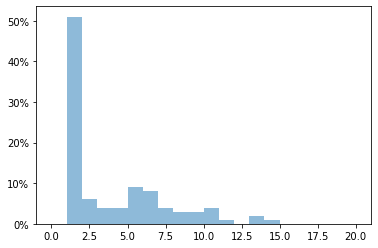

Time for epoch 91 is 0.17023706436157227 sec


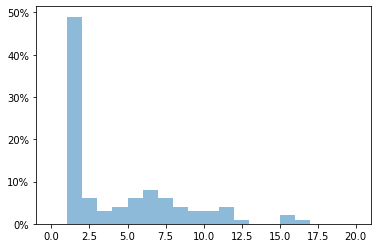

Time for epoch 92 is 0.18049144744873047 sec


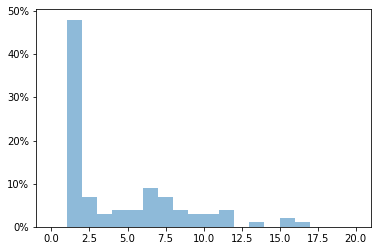

Time for epoch 93 is 0.18954849243164062 sec


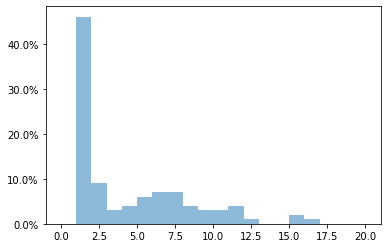

Time for epoch 94 is 0.17435002326965332 sec


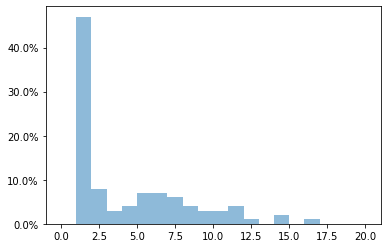

Time for epoch 95 is 0.2418673038482666 sec


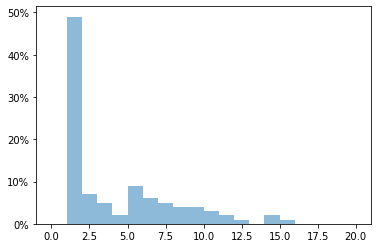

Time for epoch 96 is 0.18368315696716309 sec


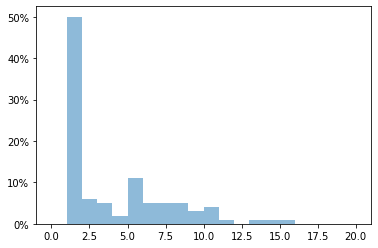

Time for epoch 97 is 0.1762392520904541 sec


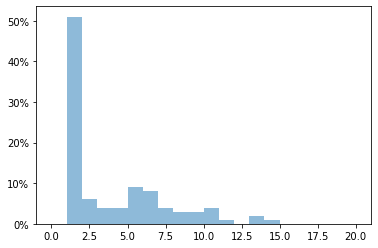

Time for epoch 98 is 0.18100523948669434 sec


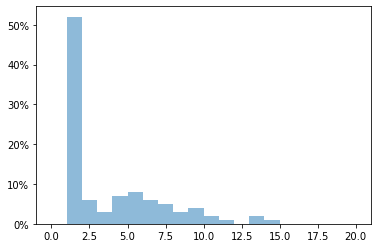

Time for epoch 99 is 0.17158889770507812 sec


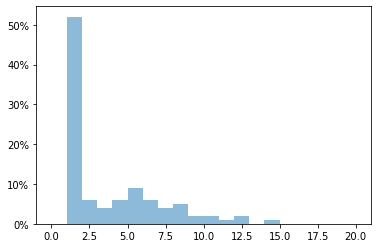

Time for epoch 100 is 0.1915726661682129 sec


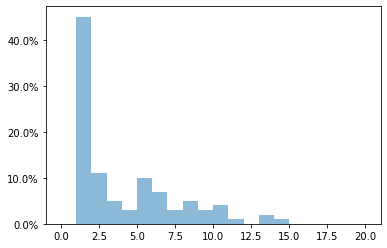

Time for epoch 101 is 0.19253849983215332 sec


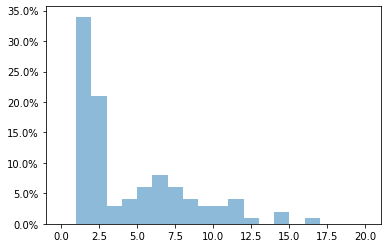

Time for epoch 102 is 0.18254375457763672 sec


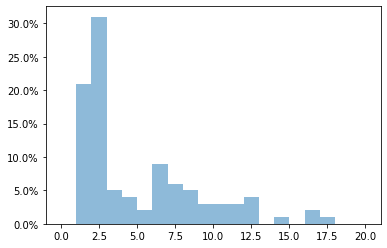

Time for epoch 103 is 0.31119537353515625 sec


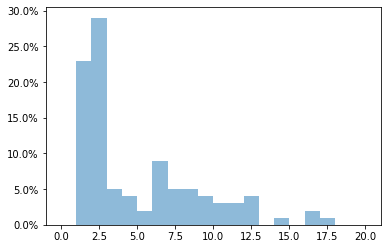

Time for epoch 104 is 0.19743084907531738 sec


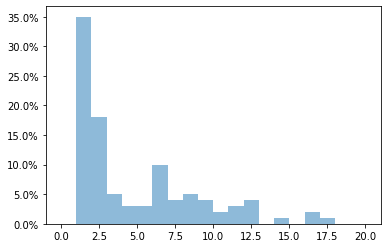

Time for epoch 105 is 0.21411490440368652 sec


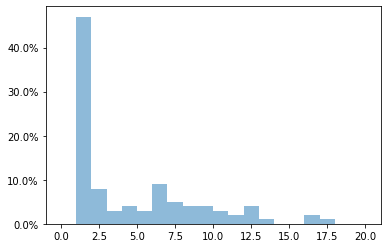

Time for epoch 106 is 0.18428707122802734 sec


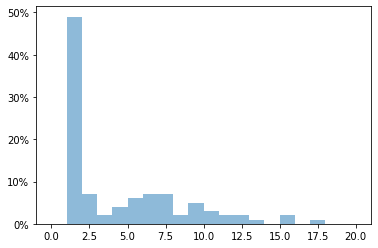

Time for epoch 107 is 0.18396234512329102 sec


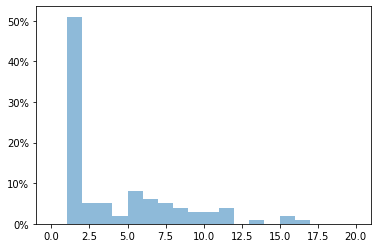

Time for epoch 108 is 0.1974184513092041 sec


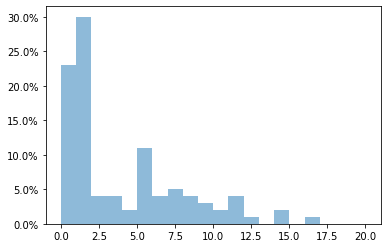

Time for epoch 109 is 0.18427181243896484 sec


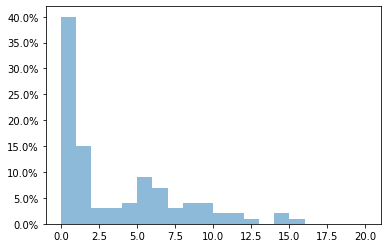

Time for epoch 110 is 0.21913766860961914 sec


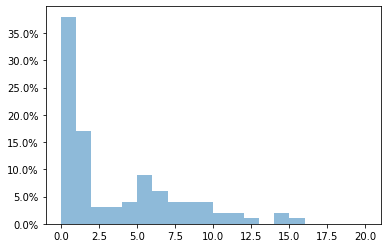

Time for epoch 111 is 0.2259223461151123 sec


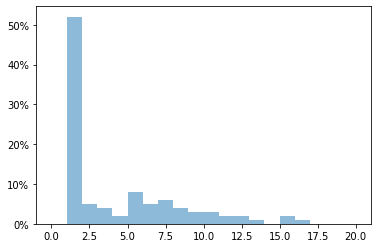

Time for epoch 112 is 0.20221328735351562 sec


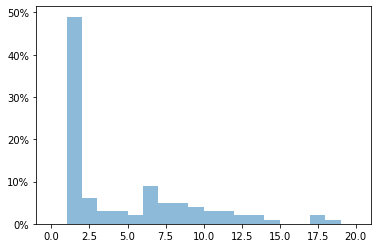

Time for epoch 113 is 0.1815812587738037 sec


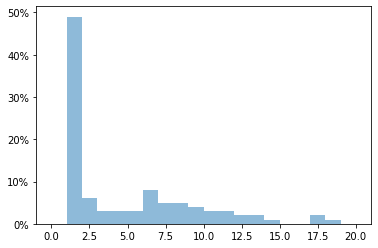

Time for epoch 114 is 0.1679058074951172 sec


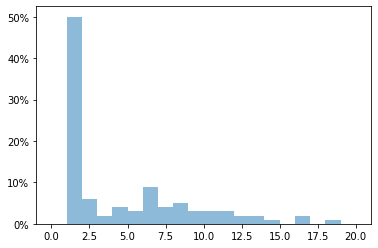

Time for epoch 115 is 0.23798751831054688 sec


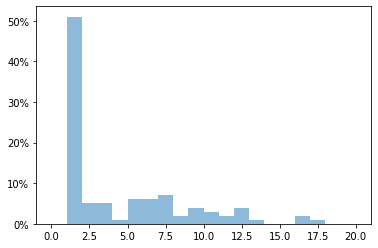

Time for epoch 116 is 0.18419647216796875 sec


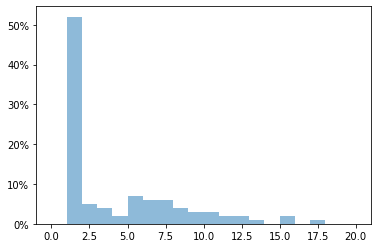

Time for epoch 117 is 0.18062472343444824 sec


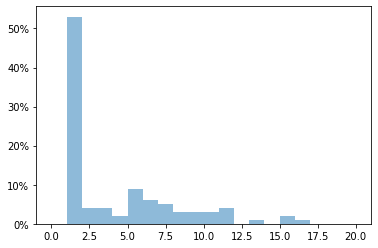

Time for epoch 118 is 0.18395209312438965 sec


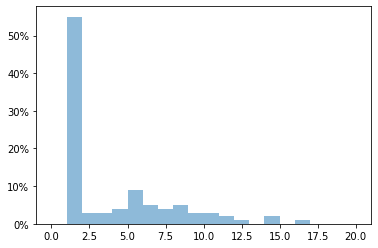

Time for epoch 119 is 0.21941256523132324 sec


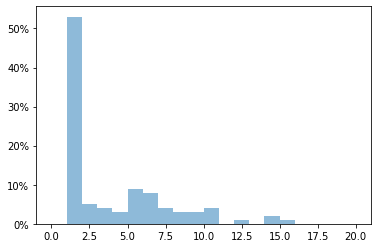

Time for epoch 120 is 0.21039056777954102 sec


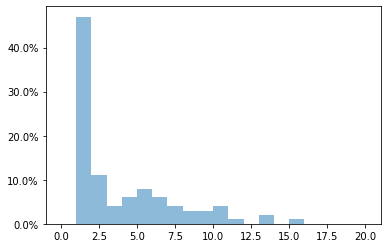

Time for epoch 121 is 0.17516088485717773 sec


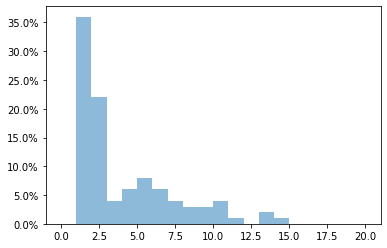

Time for epoch 122 is 0.17327213287353516 sec


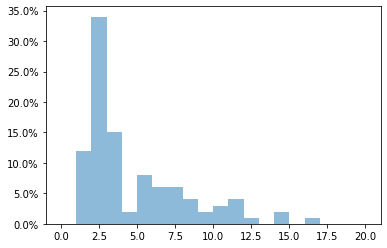

Time for epoch 123 is 0.19971227645874023 sec


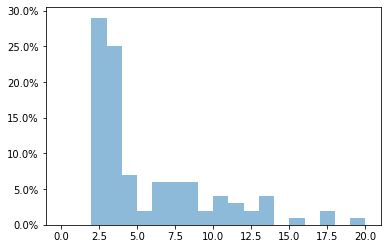

Time for epoch 124 is 0.29231739044189453 sec


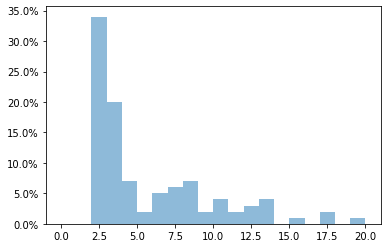

Time for epoch 125 is 0.19242548942565918 sec


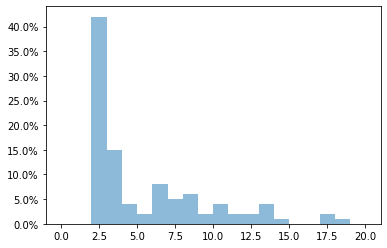

Time for epoch 126 is 0.18907451629638672 sec


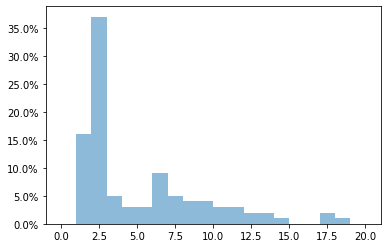

Time for epoch 127 is 0.19108796119689941 sec


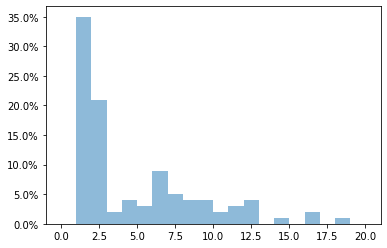

Time for epoch 128 is 0.2277514934539795 sec


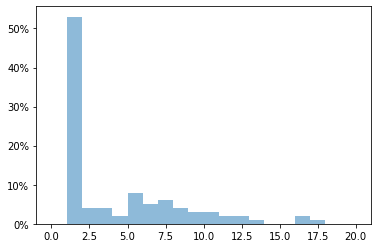

Time for epoch 129 is 0.22653555870056152 sec


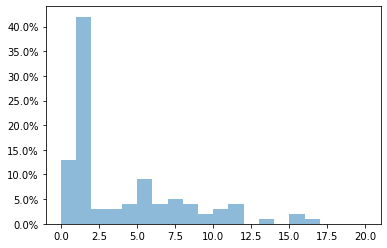

Time for epoch 130 is 0.20213747024536133 sec


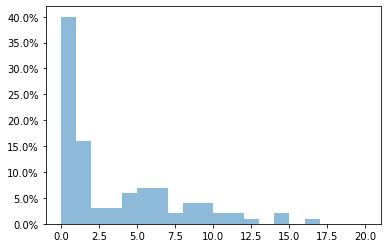

Time for epoch 131 is 0.1867542266845703 sec


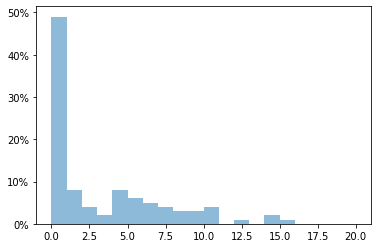

Time for epoch 132 is 0.18680047988891602 sec


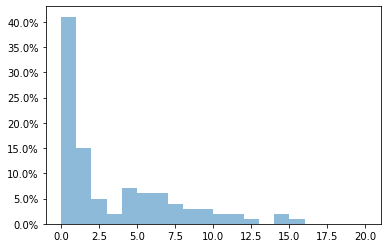

Time for epoch 133 is 0.19278478622436523 sec


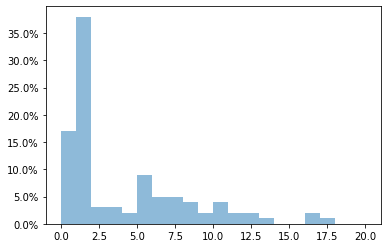

Time for epoch 134 is 0.18467497825622559 sec


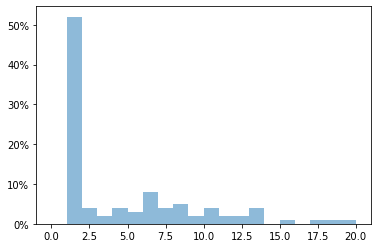

Time for epoch 135 is 0.21636390686035156 sec


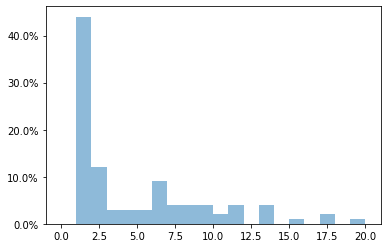

Time for epoch 136 is 0.17847204208374023 sec


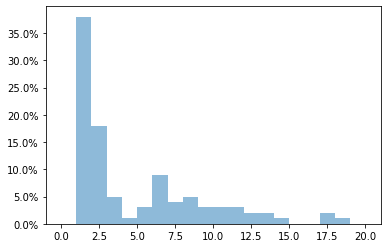

Time for epoch 137 is 0.22431063652038574 sec


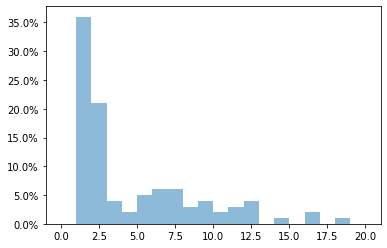

Time for epoch 138 is 0.18772363662719727 sec


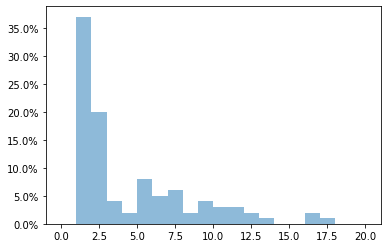

Time for epoch 139 is 0.18122458457946777 sec


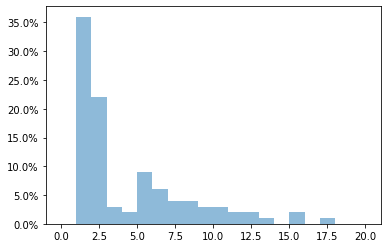

Time for epoch 140 is 0.1820821762084961 sec


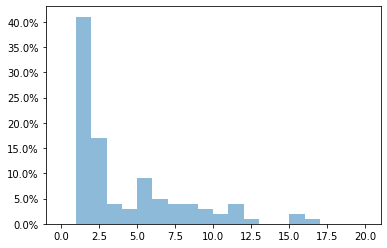

Time for epoch 141 is 0.1946725845336914 sec


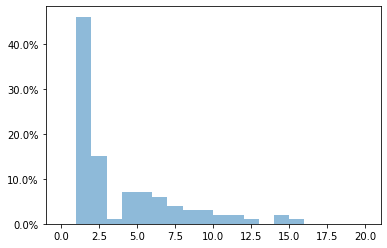

Time for epoch 142 is 0.17755651473999023 sec


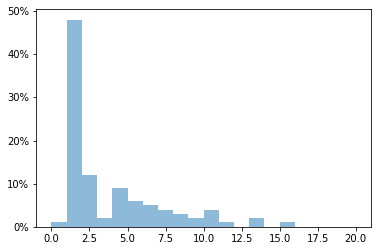

Time for epoch 143 is 0.18381333351135254 sec


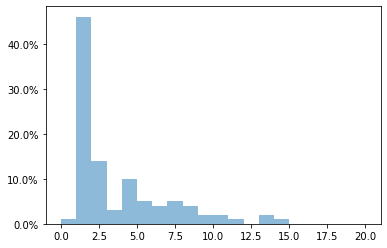

Time for epoch 144 is 0.17820191383361816 sec


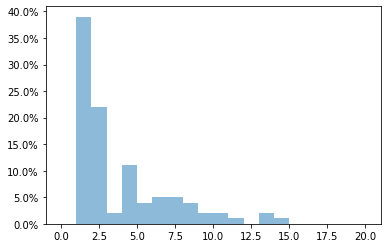

Time for epoch 145 is 0.31375622749328613 sec


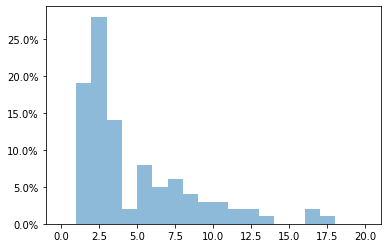

Time for epoch 146 is 0.18934082984924316 sec


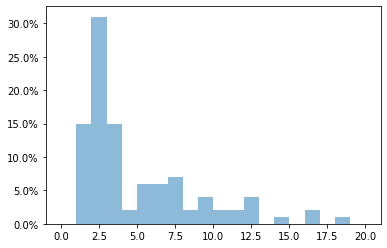

Time for epoch 147 is 0.17566871643066406 sec


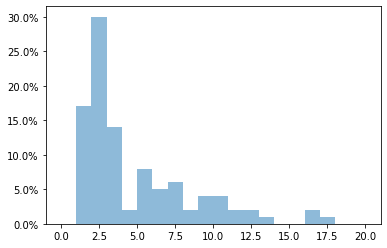

Time for epoch 148 is 0.20831584930419922 sec


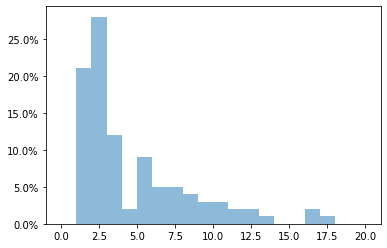

Time for epoch 149 is 0.18151354789733887 sec


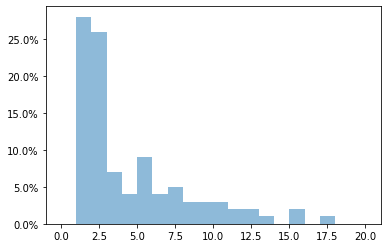

Time for epoch 150 is 0.20582032203674316 sec


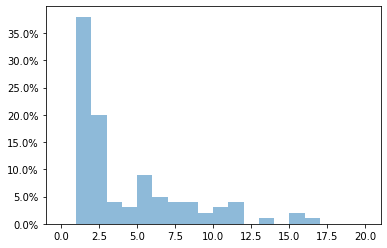

Time for epoch 151 is 0.16813158988952637 sec


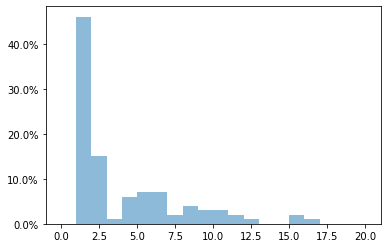

Time for epoch 152 is 0.17947888374328613 sec


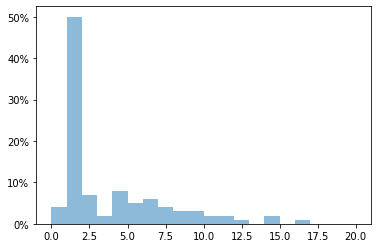

Time for epoch 153 is 0.17876482009887695 sec


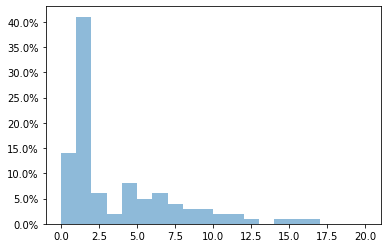

Time for epoch 154 is 0.19270658493041992 sec


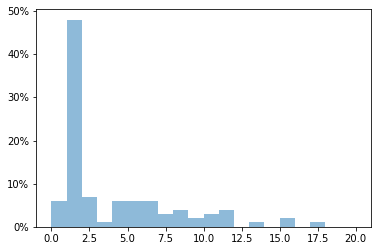

Time for epoch 155 is 0.17773056030273438 sec


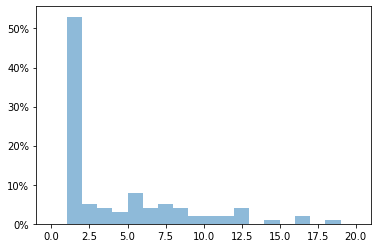

Time for epoch 156 is 0.20452165603637695 sec


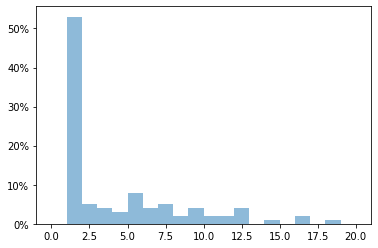

Time for epoch 157 is 0.1854259967803955 sec


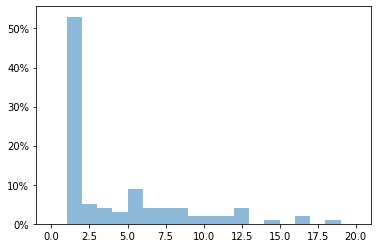

Time for epoch 158 is 0.18819665908813477 sec


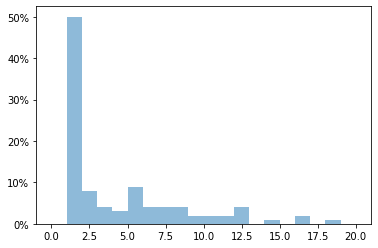

Time for epoch 159 is 0.19684338569641113 sec


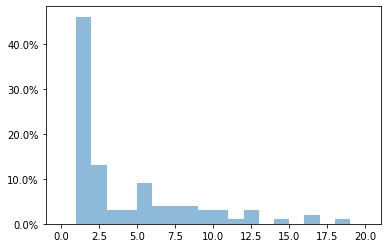

Time for epoch 160 is 0.17932462692260742 sec


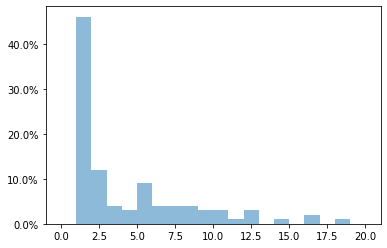

Time for epoch 161 is 0.17479848861694336 sec


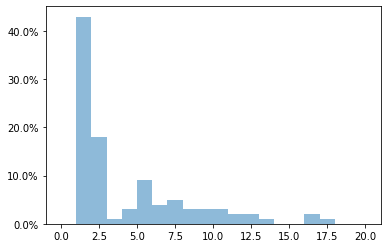

Time for epoch 162 is 0.1703486442565918 sec


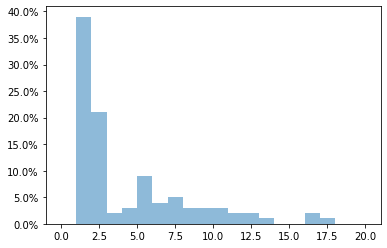

Time for epoch 163 is 0.18738341331481934 sec


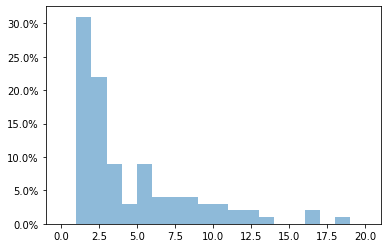

Time for epoch 164 is 0.20409774780273438 sec


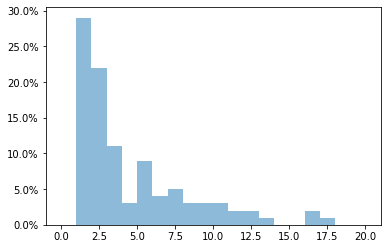

Time for epoch 165 is 0.21911311149597168 sec


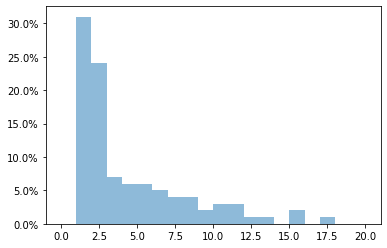

Time for epoch 166 is 0.29685068130493164 sec


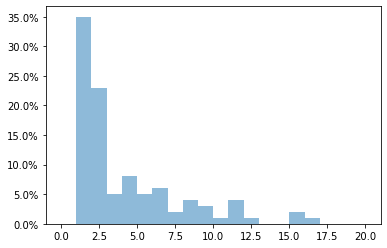

Time for epoch 167 is 0.18108081817626953 sec


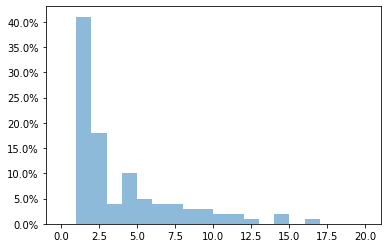

Time for epoch 168 is 0.17674541473388672 sec


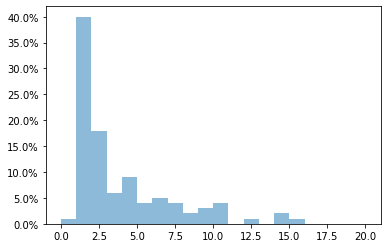

Time for epoch 169 is 0.2081441879272461 sec


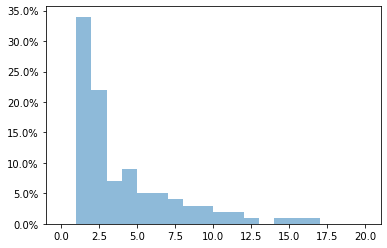

Time for epoch 170 is 0.187424898147583 sec


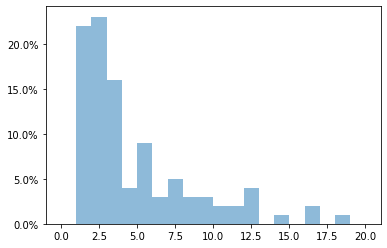

Time for epoch 171 is 0.1897139549255371 sec


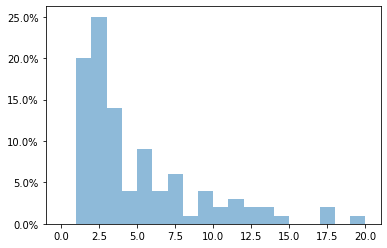

Time for epoch 172 is 0.17994213104248047 sec


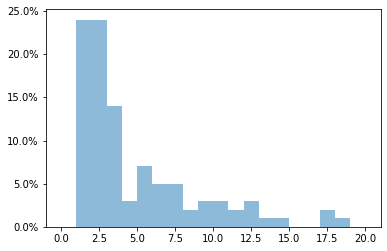

Time for epoch 173 is 0.22147512435913086 sec


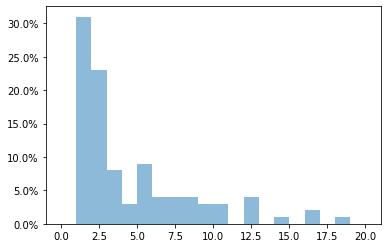

Time for epoch 174 is 0.1875011920928955 sec


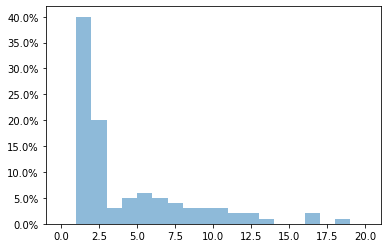

Time for epoch 175 is 0.187699556350708 sec


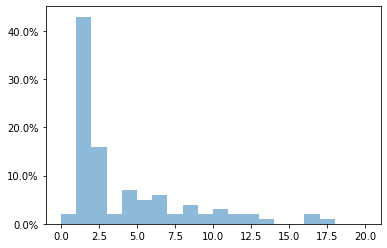

Time for epoch 176 is 0.19136738777160645 sec


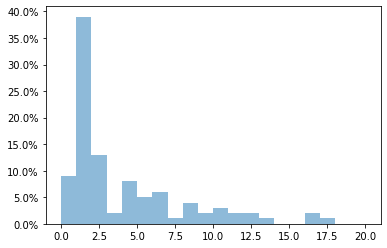

Time for epoch 177 is 0.19023633003234863 sec


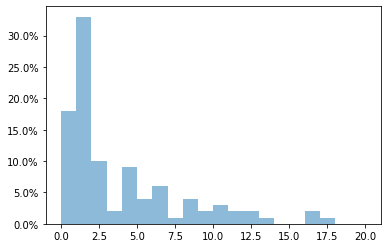

Time for epoch 178 is 0.17631006240844727 sec


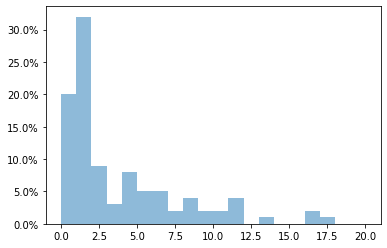

Time for epoch 179 is 0.2003638744354248 sec


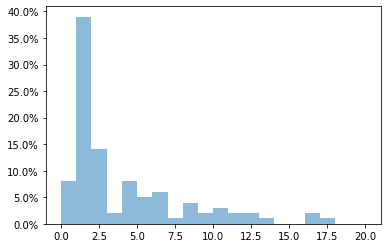

Time for epoch 180 is 0.23652243614196777 sec


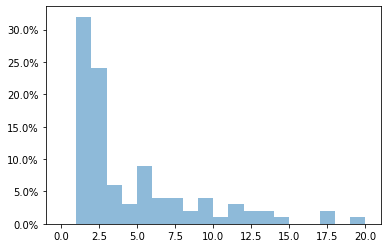

Time for epoch 181 is 0.18451380729675293 sec


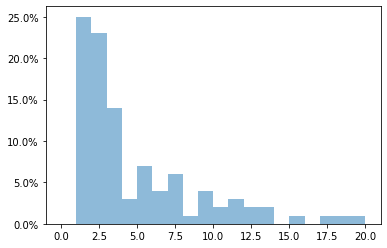

Time for epoch 182 is 0.18131113052368164 sec


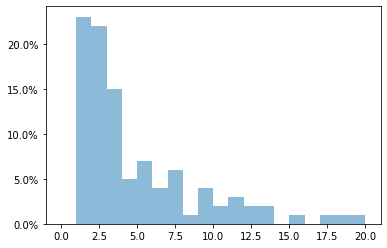

Time for epoch 183 is 0.17662501335144043 sec


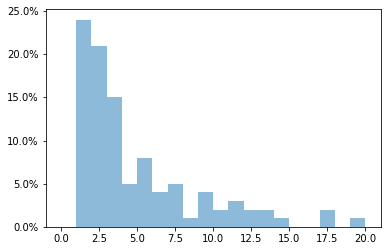

Time for epoch 184 is 0.1824047565460205 sec


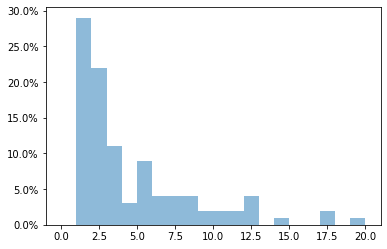

Time for epoch 185 is 0.1884009838104248 sec


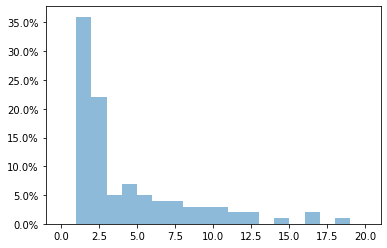

Time for epoch 186 is 0.18431997299194336 sec


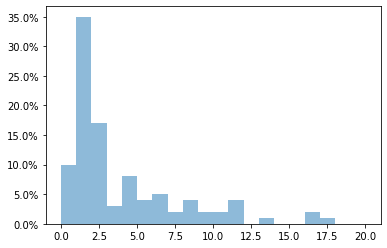

Time for epoch 187 is 0.32478928565979004 sec


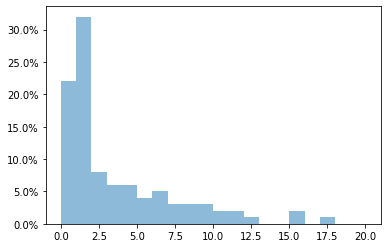

Time for epoch 188 is 0.1869974136352539 sec


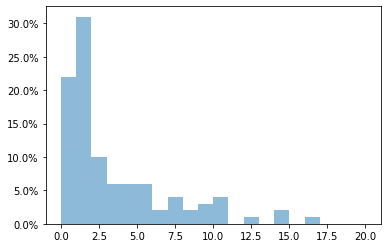

Time for epoch 189 is 0.19860219955444336 sec


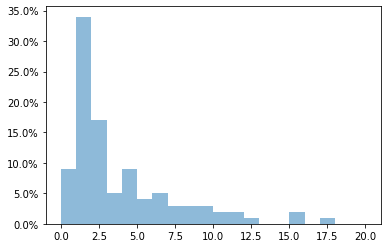

Time for epoch 190 is 0.21097278594970703 sec


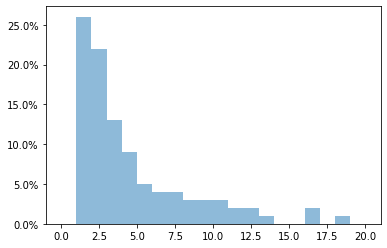

Time for epoch 191 is 0.2113335132598877 sec


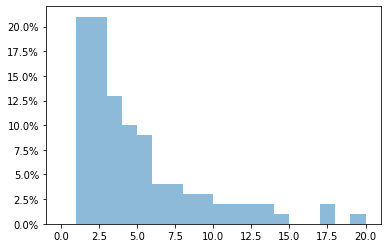

Time for epoch 192 is 0.24275970458984375 sec


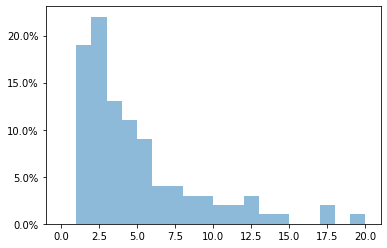

Time for epoch 193 is 0.17267060279846191 sec


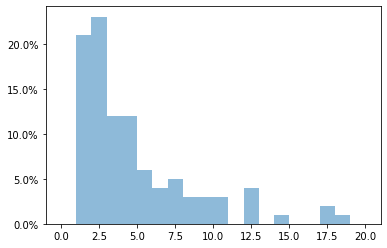

Time for epoch 194 is 0.17632126808166504 sec


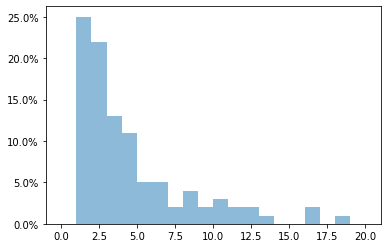

Time for epoch 195 is 0.20807647705078125 sec


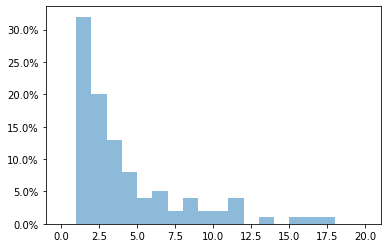

Time for epoch 196 is 0.1839921474456787 sec


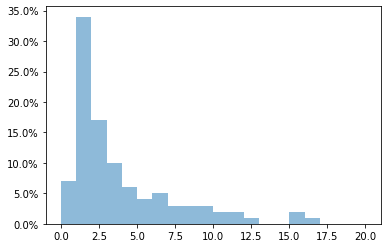

Time for epoch 197 is 0.21003937721252441 sec


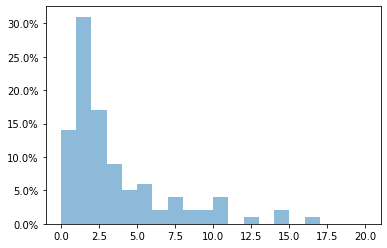

Time for epoch 198 is 0.18100738525390625 sec


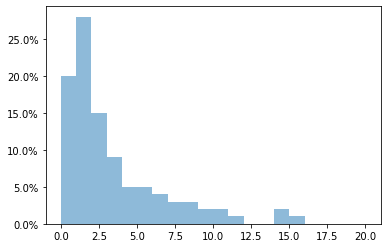

Time for epoch 199 is 0.19132781028747559 sec


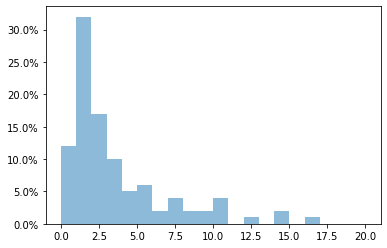

Time for epoch 200 is 0.1856677532196045 sec


In [18]:
train(data_loader, EPOCHS)

In [19]:
noise = tf.random.normal([100, 1])
generated_data = generator(noise, training=False).numpy()

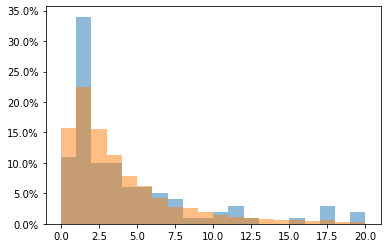

In [20]:
plt.hist(generated_data , bins = 20,  range=(0, 20), alpha=0.5, weights=np.ones(len(generated_data)) / len(generated_data))
plt.hist(data , bins = 20,  range=(0, 20), alpha=0.5, weights=np.ones(len(data)) / len(data))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()